# AMBROSM 코드 리뷰
* [링크](https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense)
* contents
    * a little bit of EDA
    * how to cross_validate correctly
    * how to preprocess the data for various classifiers
    * how to tune the most important hyperparameters of some models
    * how an ensemble performs better than any single model

## Reading the data

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

np.set_printoptions(linewidth=195, edgeitems=5)

In [3]:
data_path = '../data/'

train_df = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')
original_df = pd.read_csv(data_path+'jm1.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

In [14]:
train_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [12]:
original_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [9]:
from IPython.core.display_functions import display

with pd.option_context("display.min_rows", 7):
    display(train_df)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


## EDA
* defects는 target column, 21개의 다른 컬럼이 features다. 모든 features는 numerical하다.
* no missing values(train_df.isna().sum().sum())
* no duplicated(train_df.duplicated().sum())
* somewhat unbalanced(23%), use StratifiedKFold for cross-validation, upsampling, downsampling 불필요
* 10000라인 이상이다. 몇몇 알고리즘한테는 너무 크다.(e.g. kernel methods, neighborhood, components analysis)
* 10000라인 이상, 21개의 feature 이므로 풍부한 데이터 이다. 오버피팅을 걱정할 필요가 없다.
### 2가지 포인트
* original과 합성 데이터에는 중요한 차이가 있다. 이 문서에서는 original 데이터는 포함하지 않는다.
* 21개의 feature 모두 양수이고 분포는 right-skewed 하다. exponential distribution(지수분포)와 비슷핟. log transformation이 필요하다.

In [10]:
train_df.duplicated().sum()

0

In [11]:
dup_test = pd.DataFrame([[1,2,3],[4,5,6],[1,2,3]])
dup_test.duplicated()

0    False
1    False
2     True
dtype: bool

## original과 합성 데이터의 차이
* train과 test 데이터는 original 데이터 셋에 기반해 합성데이터로 구성된다. 분포는 같이 않다.
* original 데이터는 9개의 파생 데이터가 있다.
```
P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
V = volume on minimal implementation = (2 + mu2')log2(2 + mu2')
L = program length = V*/N
D = difficulty = 1/L
L' = 1/D
I = intelligence = L'*V'
E = effort to write program = V/L
T = time to write program = E/18 seconds
```
* origin 데이터가 합성데이터에 완전히 반영되지는 않음(아래 차트 확인)
* 최종 defects의 비율도 다름

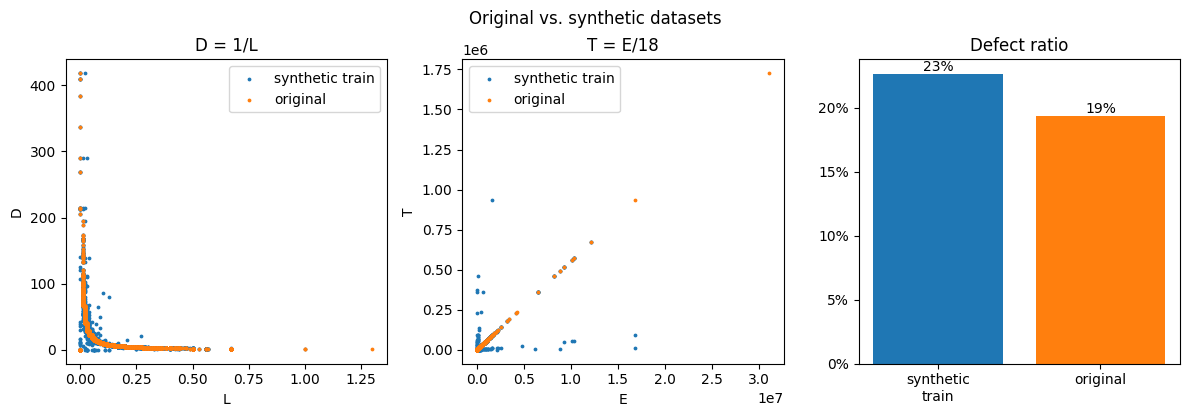

In [15]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(train_df.l, train_df.d, s=3, label='synthetic train')
ax1.scatter(original_df.l, original_df.d, s=3, label='original')
ax1.set_xlabel('L')
ax1.set_ylabel('D')
ax1.set_title('D = 1/L')
ax1.legend()
ax2.scatter(train_df.e, train_df.t, s=3, label='synthetic train')
ax2.scatter(original_df.e, original_df.t, s=3, label='original')
ax2.set_xlabel('E')
ax2.set_ylabel('T')
ax2.set_title('T = E/18')
ax2.legend()
bars1 = ax3.bar([0], [train_df.defects.mean()*100])
bars2 = ax3.bar([1], [original_df.defects.mean()*100])
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax3.bar_label(bars1, fmt='{:.0f}%')
ax3.bar_label(bars2, fmt='{:.0f}%')
ax3.set_xticks([0, 1], ['synthetic\ntrain', 'original'])
ax3.set_title('Defect ratio')
plt.tight_layout()
plt.suptitle('Original vs. synthetic datasets', y=1.03)
plt.show()

### 인사이트 : 위의 차이점을 봤을때 훈련 모델에 original 데이터를 사용하는 것을 추천하지 않음

## log-transformation 추천

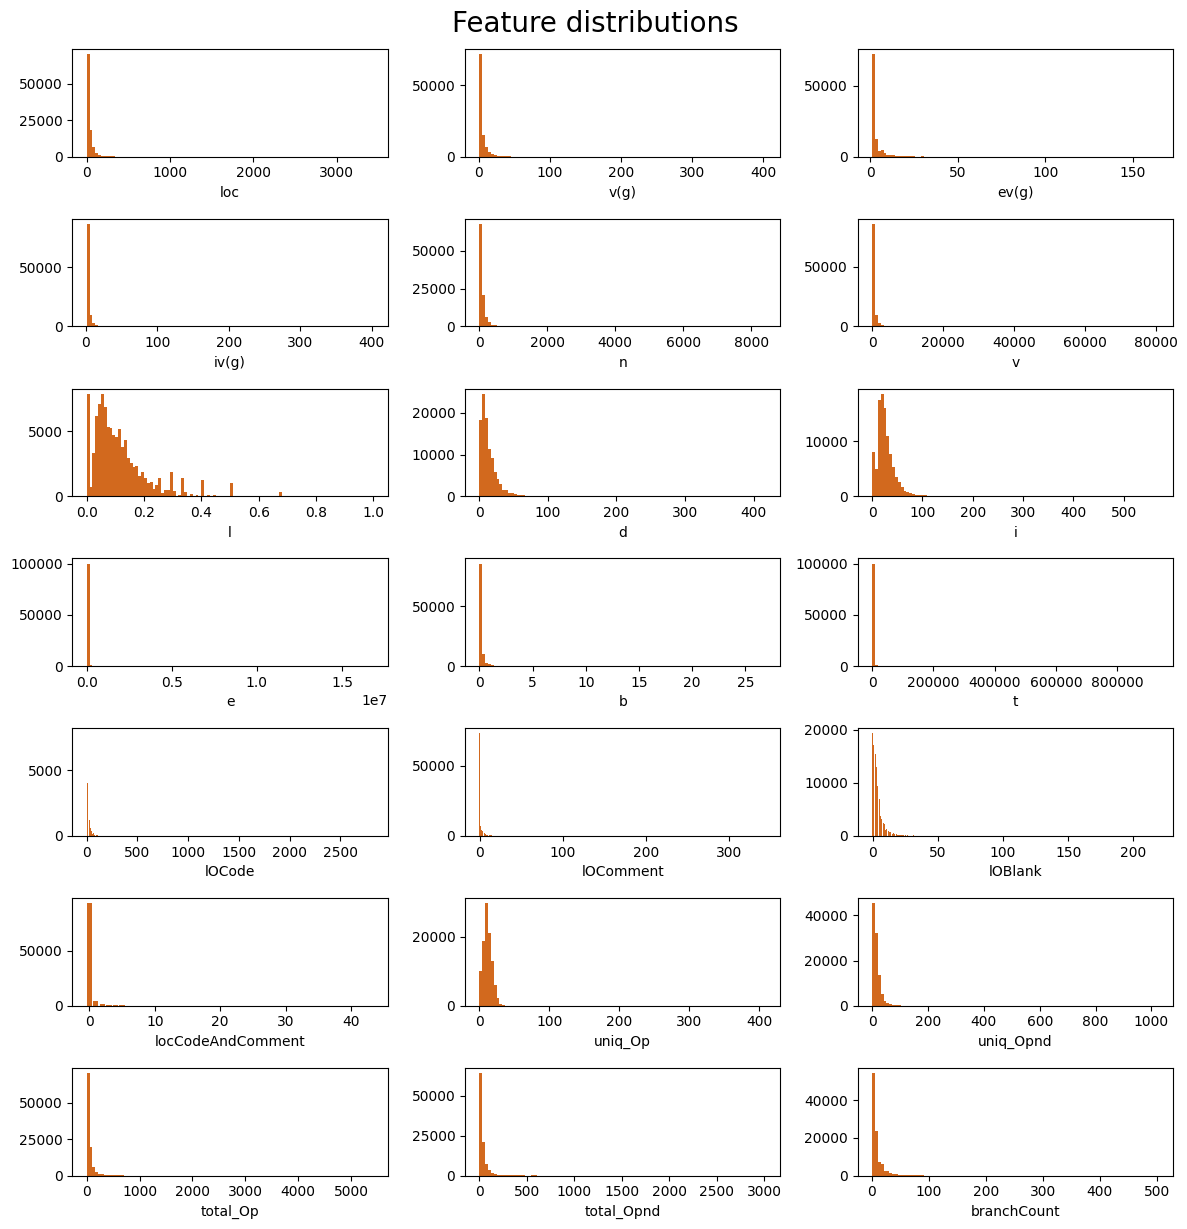

In [17]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    if train_df[col].dtype == float:
        ax.hist(train_df[col], bins=100, color='chocolate')
    else: #int
        vc = train_df[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

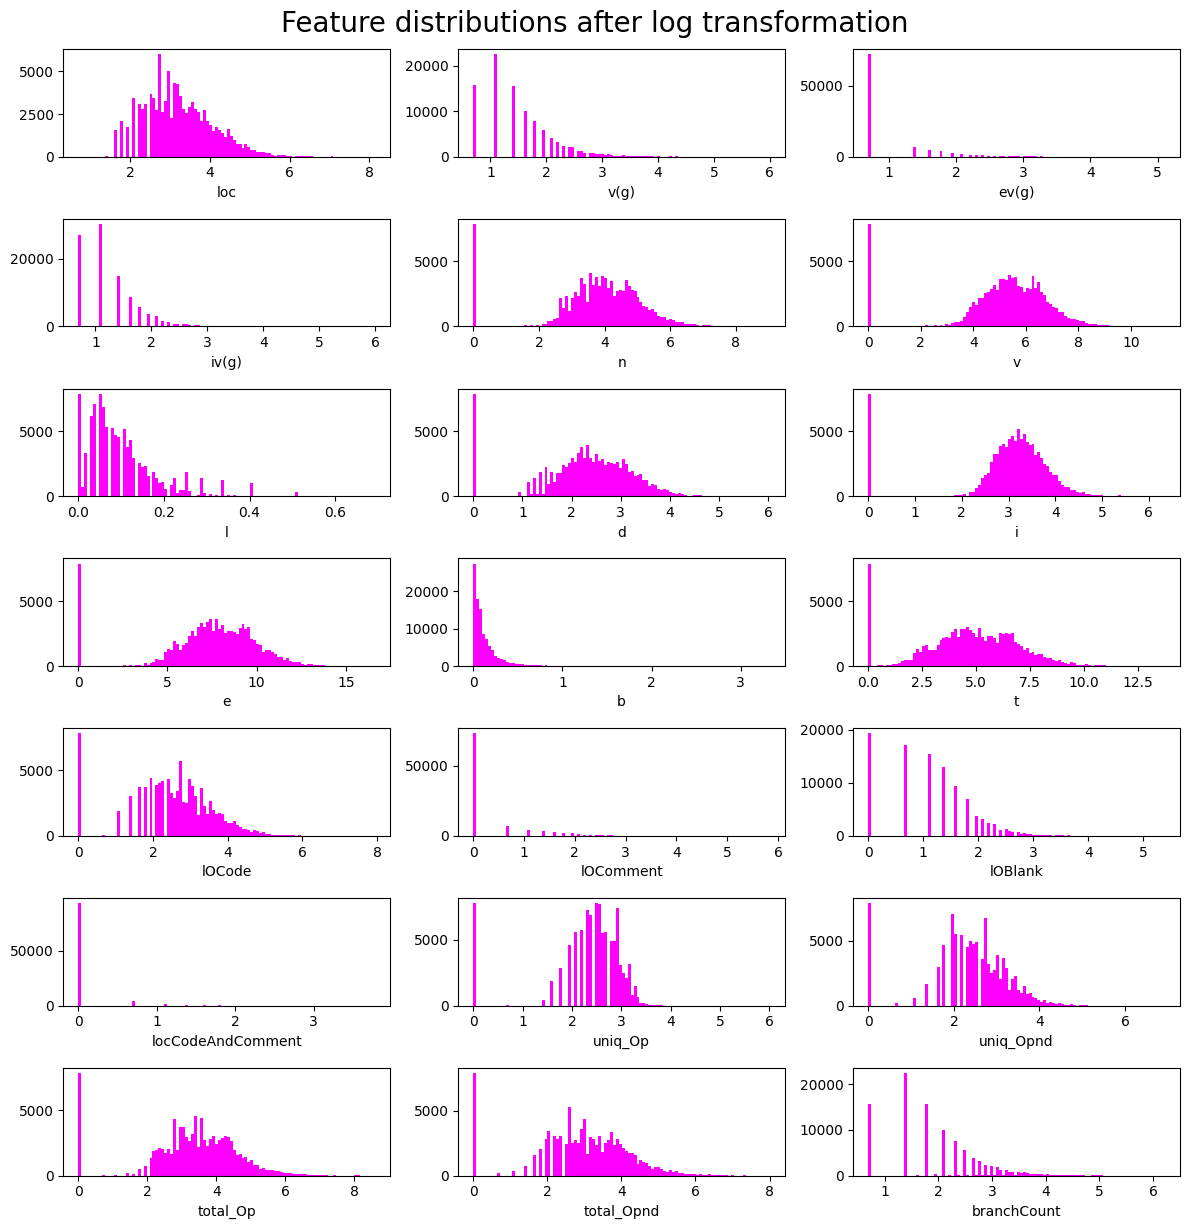

In [19]:
# 로그 함수 적용
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    ax.hist(np.log1p(train_df[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()